
## K-nearest neighbor model for predicting customer bookings

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [68]:
import pandas as pd

In [69]:
df = pd.read_csv(r"C:\Users\keith\Desktop\Portfolio Projects\British Airways\part 2\customer_booking.csv", encoding= 'ISO-8859-1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before our analysis, let's convert weekdays to numbers in dataframe

In [71]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [87]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [73]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [74]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


We'll work with all numerical columns for this analysis. First we scale the data to ensure accuracy of model results. Then, use k-nearest neighbors model for all combinations of numerical columns in customer bookings dataframe to discover if any combination of columns is significantly better at predicting customer bookings than the others. For all combinations, we test k-values 1-15 and pick the best scoring k-value, and store that in a dictionary with keys consisting of column combinations, and values consisting of k-values and accuracy of the model.

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from itertools import combinations

# we'll use all columns with numerical values, and scale the data before analysis
df1 = df[list(df.describe().columns)]
df_without_cat = df1.drop(columns=['flight_day','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals'])

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_without_cat.to_numpy()[:,:-1])
df_scaled = pd.DataFrame(df_scaled, columns=list(df_without_cat.columns)[:-1])
df_scaled['booking_complete'] = df['booking_complete']
df_scaled['flight_day'] = df['flight_day']
df_scaled['wants_extra_baggage'] = df['wants_extra_baggage']
df_scaled['wants_preferred_seat'] = df['wants_preferred_seat']
df_scaled['wants_in_flight_meals'] = df['wants_in_flight_meals']
df_scaled['booking_complete'] = df['booking_complete']

print("Scaled Dataset Using MinMaxScaler")
display(df_scaled.head())

# test all possible combinations of predictors k-values 1-15, choose the best performing k and store it in a dictionary
# where key = column combination and value = k
col_comb = list(combinations(list(df.describe().columns)[:-1], 2))

col_comb_dic = {}
for col1, col2 in col_comb:
    temp_df = df_scaled[[col1, col2, 'booking_complete']]
    # Create feature and target arrays
    X = temp_df[[col1, col2]]
    y = temp_df['booking_complete']

    # Split into training and test set
    X_train, X_test, y_train, y_test = train_test_split(
                 X, y, test_size = 0.2, random_state=42)
    
    # train columns and then get score. find best scoring k-value and store it in col_comb_dic dictionary
    acc = []
    for k in range(1,16):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        acc.append(knn.score(X_test, y_test))
    
    best_k = acc.index(max(acc)) + 1
    col_comb_dic[(col1, col2)] = (best_k, max(acc))

Scaled Dataset Using MinMaxScaler


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration,booking_complete,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals
0,0.125,0.302191,0.024422,0.304348,0.175983,0,6,1,0,0
1,0.000,0.129181,0.025707,0.130435,0.175983,0,6,0,0,0
2,0.125,0.280277,0.028278,0.739130,0.175983,0,3,1,1,0
3,0.000,0.110727,0.039846,0.173913,0.175983,0,6,0,0,1
4,0.125,0.078431,0.028278,0.652174,0.175983,0,3,1,0,1


In [76]:
col_comb_dic = dict(sorted(col_comb_dic.items(), key=lambda item: item[1][1]))
col_comb_dic

{('length_of_stay', 'flight_hour'): (10, 0.847),
 ('purchase_lead', 'flight_duration'): (14, 0.8499),
 ('purchase_lead', 'flight_hour'): (12, 0.8513),
 ('flight_hour', 'flight_duration'): (15, 0.8514),
 ('length_of_stay', 'flight_duration'): (10, 0.8515),
 ('wants_preferred_seat', 'flight_duration'): (4, 0.8516),
 ('length_of_stay', 'flight_day'): (10, 0.8517),
 ('num_passengers', 'purchase_lead'): (10, 0.8518),
 ('purchase_lead', 'length_of_stay'): (12, 0.8519),
 ('num_passengers', 'length_of_stay'): (10, 0.852),
 ('num_passengers', 'flight_hour'): (8, 0.852),
 ('num_passengers', 'flight_day'): (8, 0.852),
 ('num_passengers', 'wants_extra_baggage'): (2, 0.852),
 ('num_passengers', 'wants_preferred_seat'): (2, 0.852),
 ('num_passengers', 'wants_in_flight_meals'): (2, 0.852),
 ('num_passengers', 'flight_duration'): (8, 0.852),
 ('purchase_lead', 'flight_day'): (14, 0.852),
 ('purchase_lead', 'wants_extra_baggage'): (12, 0.852),
 ('purchase_lead', 'wants_preferred_seat'): (14, 0.852),
 (

There is no significant difference in model accuracies for all columns, so I will stick with flight_hour and flight_day for my analysis

In [77]:
col_comb_dic[('flight_hour','flight_day')]

(6, 0.852)

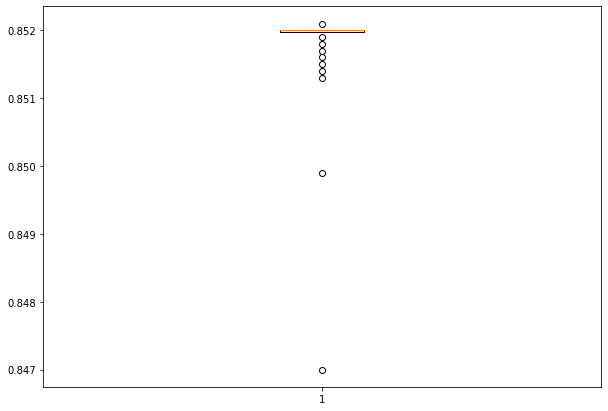

In [78]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
  
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
data = [tup[1] for tup in list(col_comb_dic.values())]
plt.boxplot(data)
 
# show plot
plt.show()

We can see the difference between the least and most accurate columns is less than 1%.

Now we'll perform cross-validation using our chosen columns, along with the best k-value for those columns. We see that the cross-validation tests perform at around the same accuracy as before.

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

df = df[['flight_hour', 'flight_day', 'booking_complete']]

# Create feature and target arrays
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

#Implementing cross validation
kf = KFold(n_splits=5, random_state=None)
model = KNeighborsClassifier(n_neighbors=6)
result = cross_val_score(model , X, y, cv = kf)
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.84572


In [80]:
booking_completed = df[df['booking_complete'] == 1]
booking_not_completed = df[df['booking_complete'] == 0]

In [81]:
booking_completed.describe()

,flight_hour,flight_day,booking_complete
count,7478.000000,7478.000000,7478.0
mean,9.158331,3.781225,1.0
std,5.236860,1.969952,0.0
min,0.000000,1.000000,1.0
25%,5.000000,2.000000,1.0
50%,9.000000,4.000000,1.0
75%,13.000000,5.000000,1.0
max,23.000000,7.000000,1.0


In [82]:
booking_not_completed.describe()

,flight_hour,flight_day,booking_complete
count,42522.000000,42522.000000,42522.0
mean,9.050162,3.820258,0.0
std,5.442888,1.996747,0.0
min,0.000000,1.000000,0.0
25%,5.000000,2.000000,0.0
50%,9.000000,4.000000,0.0
75%,13.000000,5.000000,0.0
max,23.000000,7.000000,0.0


Plot the number of customers that booked on each unique weekday, parsing by whether booking was completed or not. Do the same for the hour of the day.

<AxesSubplot:xlabel='flight_day'>

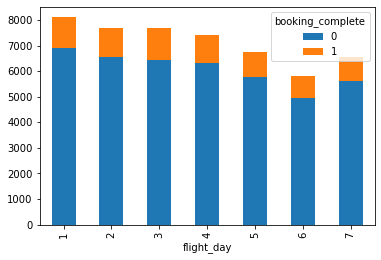

In [88]:
pd.crosstab(df['flight_day'],df['booking_complete']).plot.bar(stacked=True)

<AxesSubplot:xlabel='flight_hour'>

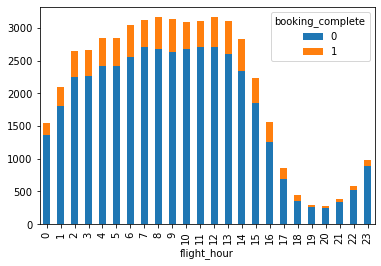

In [84]:
pd.crosstab(df['flight_hour'],df['booking_complete']).plot.bar(stacked=True)